In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
import os
import torch


In [2]:
# create a data frame from the car data with the 
# following columns: image file, label

# get the list of files in the directory
files = os.listdir('car_data')
# create a data frame
df = pd.DataFrame(columns=['file', 'label'])

for file in files:
    result = file.split('_')
    df.loc[len(df)] = [file, result[0]]




In [3]:
df.head()

,file,label
0,Ford_Flex_2010_39_19_260_35_6_75_68_201_16_AWD...,Ford
1,Chevrolet_Suburban_2011_41_17_320_53_8_79_76_n...,Chevrolet
2,Nissan_Maxima_2011_31_18_290_35_6_73_57_190_19...,Nissan
3,Chevrolet_Silverado 1500_2014_45_20_350_53_8_8...,Chevrolet
4,Dodge_Durango_2019_45_20_290_36_6_75_70_201_18...,Dodge


In [4]:
# gets rids of the car brands that have less than 2000 images
value_counts = df['label'].value_counts()
values_to_drop = value_counts[value_counts < 4000].index

df = df[~df['label'].isin(values_to_drop)]
df['label'].value_counts()

label
Chevrolet    5079
Toyota       4598
Ford         4416
BMW          4121
Name: count, dtype: int64

In [5]:
df.head()

,file,label
0,Ford_Flex_2010_39_19_260_35_6_75_68_201_16_AWD...,Ford
1,Chevrolet_Suburban_2011_41_17_320_53_8_79_76_n...,Chevrolet
3,Chevrolet_Silverado 1500_2014_45_20_350_53_8_8...,Chevrolet
7,Chevrolet_Blazer_2020_34_18_230_20_4_76_67_191...,Chevrolet
13,Chevrolet_Sonic_2016_15_15_130_18_4_68_59_173_...,Chevrolet


In [6]:
# 

In [81]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['file'], df['label'], test_size=0.999, random_state=42)


In [69]:
# X_train.head()
X_test.head()
# y_train.head()

22928         Ford
17922          BMW
18940    Chevrolet
8492        Toyota
2571          Ford
Name: label, dtype: object

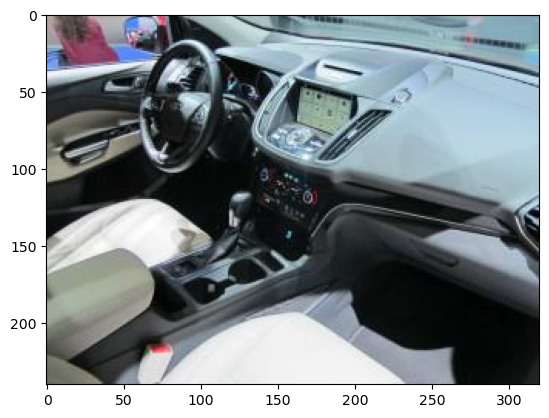

In [82]:
# show the first image
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open('car_data/' + X_train.iloc[0])
plt.imshow(img)

In [83]:
# convert the image into 255x255 tensor
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((255, 255)),
    transforms.ToTensor()
])

img = transform(img)
img.shape

img



tensor([[[0.7412, 0.7333, 0.7216,  ..., 0.4863, 0.4902, 0.4980],
         [0.7294, 0.7255, 0.7176,  ..., 0.4863, 0.4902, 0.4980],
         [0.7137, 0.7176, 0.7137,  ..., 0.4980, 0.5098, 0.5255],
         ...,
         [0.4118, 0.4196, 0.4275,  ..., 0.1255, 0.1294, 0.1373],
         [0.4000, 0.4078, 0.4196,  ..., 0.1255, 0.1333, 0.1412],
         [0.3961, 0.4000, 0.4078,  ..., 0.1255, 0.1333, 0.1451]],

        [[0.6784, 0.6745, 0.6627,  ..., 0.6235, 0.6275, 0.6353],
         [0.6627, 0.6627, 0.6588,  ..., 0.6235, 0.6275, 0.6353],
         [0.6471, 0.6510, 0.6510,  ..., 0.6353, 0.6471, 0.6627],
         ...,
         [0.4196, 0.4275, 0.4353,  ..., 0.1412, 0.1451, 0.1529],
         [0.4078, 0.4157, 0.4275,  ..., 0.1412, 0.1490, 0.1569],
         [0.4039, 0.4078, 0.4157,  ..., 0.1412, 0.1490, 0.1608]],

        [[0.6471, 0.6471, 0.6353,  ..., 0.6980, 0.7020, 0.7098],
         [0.6353, 0.6353, 0.6314,  ..., 0.6980, 0.7020, 0.7098],
         [0.6196, 0.6235, 0.6235,  ..., 0.7098, 0.7216, 0.

In [49]:
y_train.head()

22928         Ford
17922          BMW
18940    Chevrolet
8492        Toyota
2571          Ford
Name: label, dtype: object

In [84]:
# transform all images to tensor
X_train_tensors = []
X_test_tensors = []

for i in range(len(X_train)):
    img = Image.open('car_data/' + X_train.iloc[i])
    X_train_tensors.append(transform(img))

for i in range(len(X_test)):
    img = Image.open('car_data/' + X_test.iloc[i])
    transformed_img = transform(img)
    X_test_tensors.append(transformed_img)




In [85]:
# label encoding, ford = 1, bmw = 2, toyota = 3, chevrolet = 4
y_train = y_train.map({'Ford': 0, 'BMW': 1, 'Toyota': 2, 'Chevrolet': 3})
y_test = y_test.map({'Ford': 0, 'BMW': 1, 'Toyota': 2, 'Chevrolet': 3})

In [87]:

print(y_train.values)

[0 1 3 2 0 2 0 2 1 1 0 0 2 1 2 0 2 0]


In [88]:
y_train_tensors = torch.tensor(y_train.values)
y_test_tensors = torch.tensor(y_test.values)


In [89]:
print(y_train_tensors)

tensor([0, 1, 3, 2, 0, 2, 0, 2, 1, 1, 0, 0, 2, 1, 2, 0, 2, 0])
3


In [90]:
X_train_tensors = torch.stack(X_train_tensors)
X_test_tensors = torch.stack(X_test_tensors)

In [91]:
print(X_train_tensors.shape)

torch.Size([18, 3, 255, 255])


In [15]:
X_train.info()

<class 'pandas.core.series.Series'>
Index: 18 entries, 22928 to 55844
Series name: file
Non-Null Count  Dtype 
--------------  ----- 
18 non-null     object
dtypes: object(1)
memory usage: 288.0+ bytes


In [92]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(16, 8, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(31752, 32),
    nn.ReLU(),
    nn.Linear(32, 4),
    nn.Softmax()
)
model.to(device='cpu')
print(model)


Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=31752, out_features=32, bias=True)
  (8): ReLU()
  (9): Linear(in_features=32, out_features=4, bias=True)
  (10): Softmax(dim=None)
)


In [17]:
# hyper parameters

criterion = nn.CrossEntropyLoss()
learning_rate = 0.001
epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
print(X_train_tensors.shape, y_train.shape)

torch.Size([18, 3, 255, 255]) (18,)


In [19]:
print(X_test_tensors[0].shape)

torch.Size([3, 255, 255])


In [20]:
print(type(X_train_tensors))

<class 'torch.Tensor'>


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [95]:
losses = []
for epoch in range(10):
    
    y_pred =  model(X_train_tensors)
    print(y_pred.shape, 8*64*64)
    print(y_pred[0], y_train_tensors[0])
    loss = criterion(y_pred, y_train_tensors)
    print(f'Epoch {epoch + 1}, loss = {loss.item()}')
    losses.append(loss.item())

    model.zero_grad()
    loss.backward()

    optimizer.step()

torch.Size([18, 4]) 32768
tensor([0.2230, 0.2492, 0.2857, 0.2421], grad_fn=<SelectBackward0>) tensor(0)
Epoch 1, loss = 1.3848011493682861
torch.Size([18, 4]) 32768
tensor([0.2230, 0.2492, 0.2857, 0.2421], grad_fn=<SelectBackward0>) tensor(0)
Epoch 2, loss = 1.3848011493682861
torch.Size([18, 4]) 32768
tensor([0.2230, 0.2492, 0.2857, 0.2421], grad_fn=<SelectBackward0>) tensor(0)
Epoch 3, loss = 1.3848011493682861
torch.Size([18, 4]) 32768
tensor([0.2230, 0.2492, 0.2857, 0.2421], grad_fn=<SelectBackward0>) tensor(0)
Epoch 4, loss = 1.3848011493682861
torch.Size([18, 4]) 32768
tensor([0.2230, 0.2492, 0.2857, 0.2421], grad_fn=<SelectBackward0>) tensor(0)
Epoch 5, loss = 1.3848011493682861
torch.Size([18, 4]) 32768
tensor([0.2230, 0.2492, 0.2857, 0.2421], grad_fn=<SelectBackward0>) tensor(0)
Epoch 6, loss = 1.3848011493682861
torch.Size([18, 4]) 32768
tensor([0.2230, 0.2492, 0.2857, 0.2421], grad_fn=<SelectBackward0>) tensor(0)
Epoch 7, loss = 1.3848011493682861
torch.Size([18, 4]) 32768
t

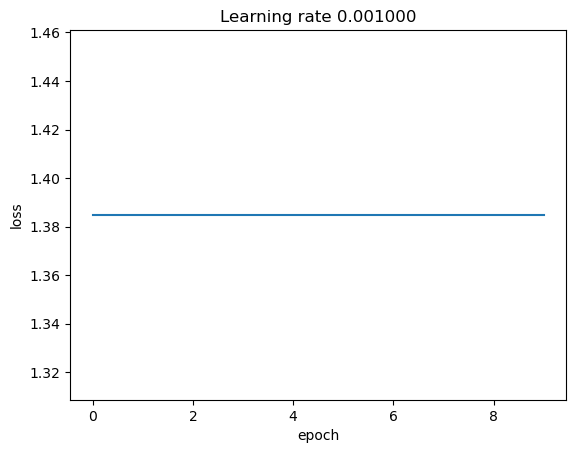

In [96]:
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

In [ ]:
# test on the test set
